In [3]:
# import stuff
import os
cwd = os.getcwd()
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import json
import re
# import json
#from textwrap import wrap 
#from collections import Counter
#from nltk.corpus import stopwords
#stopw=set(stopwords.words('english'))
%matplotlib inline 
# display matplotlib plots in jupyter
# plt.ioff() 
# stops graphs from over writing eachother
import glob

# New York Census, race data

In [2]:
files = sorted(glob.glob('Data/*Race*geojson'))
files

['Data/NY_Census_Race_Data__R_Manipulated-Percent.geojson']

In [3]:
with open(files[0]) as f:
    data = json.load(f)

In [5]:
NYC_COUNTIES = {'005': 'Bronx','047': 'Brooklyn','061': 'Manhattan','081': 'Queens', '085': 'Staten Island'}
def try_to_cast(x):
    try:
        x = float(x)
    except ValueError:
        if x == '#DIV/0!':
            x = 0
    return x

def load_json_to_df(filename, identifying_func):
    with open(filename) as f:
        data = json.load(f)['features']
    df = []
    for d in data:
        row = d['properties']
        if row['COUNTYFP10'] not in NYC_COUNTIES.keys():
            continue
        row_data = dict((k, try_to_cast(v)) for (k, v) in row.items() if identifying_func(k))
        row_data['County'] = NYC_COUNTIES[row['COUNTYFP10']]
        census_tract = re.search('Census Tract ([0-9.]+)', row['NAME']).groups()[0]
        df.append(pd.DataFrame(row_data, index=[census_tract]))
    df = pd.concat(df).reset_index()
    df = df.rename(columns={'index': 'Census_tract'})
    return df

In [6]:
identifying_func = lambda x: 'P003' in x
df = load_json_to_df(files[0], identifying_func)

In [7]:
plot_df = pd.melt(df, id_vars=['County', 'Census_tract'])

For whatever reason, there's one census tract in the Bronx that has a really large population, the only one with more than 20,000. If you look at the [interactive census map](https://www.mapbox.com/mapbox-gl-js/style-spec/), they break that block up in multiple smaller ones, but for some reason this data set does not (it's way up at the north of the Bronx, census tract 462.01).

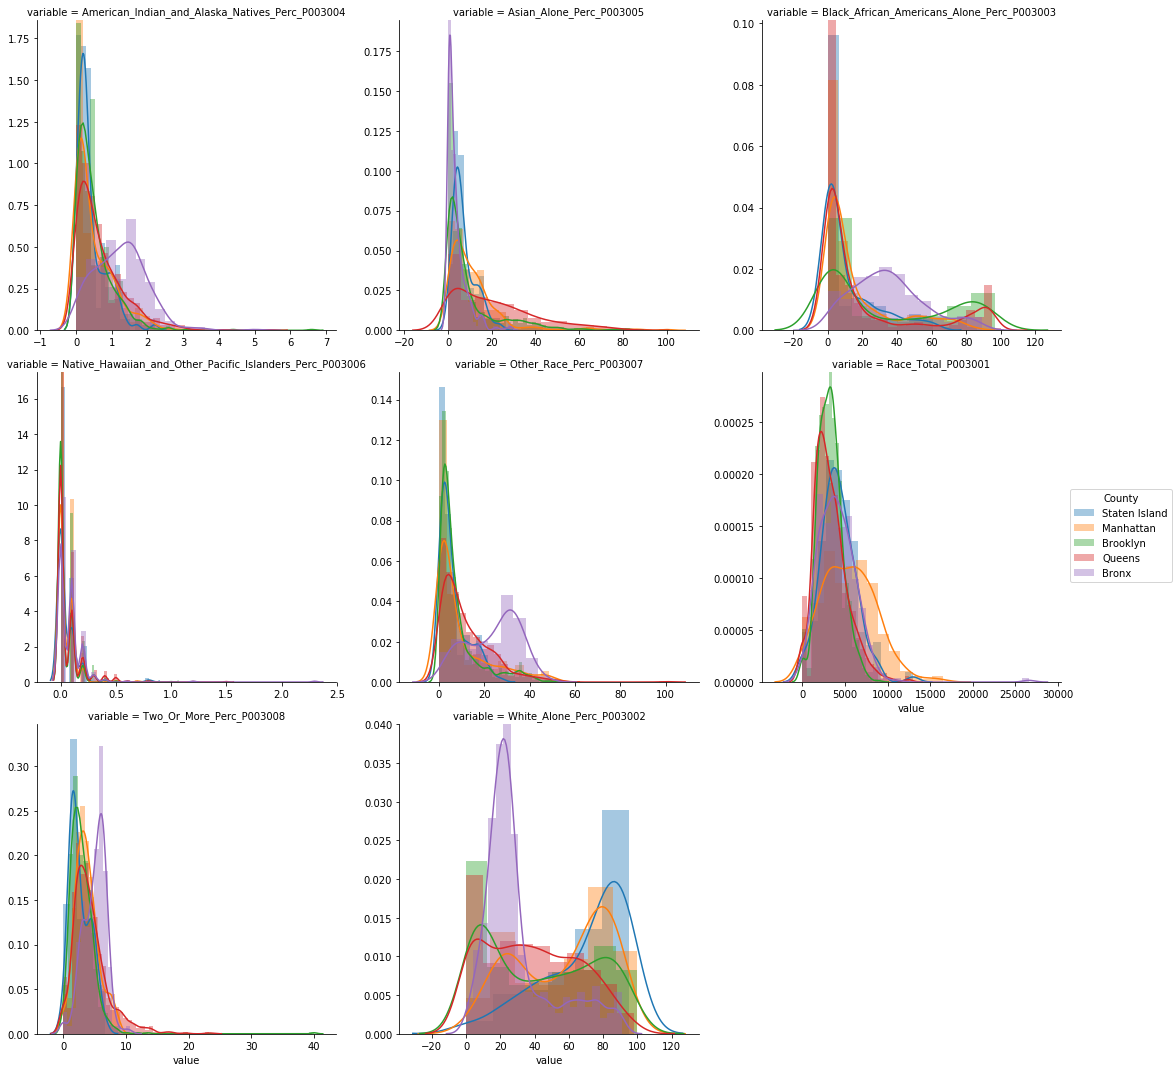

In [8]:
g = sns.FacetGrid(plot_df, col='variable', hue='County', col_wrap=3, size=5, sharex=False, sharey=False)
g.map(sns.distplot, 'value')
g.add_legend()

# New York City zoning data

In [9]:
with open('Data/nyzd.json') as f:
    data = json.load(f)

In [10]:
data['features'][5]['properties']

{'Shape_Area': 75618.3144208, 'Shape_Leng': 1147.58486519, 'ZONEDIST': 'C4-4D'}

In [11]:
# from https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/zoningtaxlotdatabase_datadictionary.pdf?r=1217
def zoning_definitions(x):
    if x.startswith('R'):
        return 'Residential'
    elif x.startswith('C'):
        return 'Commercial'
    elif x == 'BPC':
        return 'Battery Park City'
    elif x == 'PARK':
        return 'New York City Parks'
    elif x == 'PARKNYS':
        return 'New York State Parks'
    elif x == 'PARKUS':
        return 'United States Parks'
    elif x == 'ZNA':
        return 'Zoning not applicable'
    elif x == 'ZR 11-151':
        return 'Special zone in Queens'
    elif '/R' in x:
        return 'Mixed manufacturing and residential'
    elif x.startswith('M'):
        return 'Manufacturing'
    else:
        return x

def try_to_cast(x):
    try:
        x = float(x)
    except ValueError:
        if x == '#DIV/0!':
            x = 0
    return x

def load_json_to_df(filename):
    with open(filename) as f:
        data = json.load(f)['features']
    df = []
    for d in data:
        row = d['properties']
        df.append(pd.DataFrame({'zone_designation': row['ZONEDIST']}, index=[row['OBJECTID']]))
    df = pd.concat(df).reset_index()
    df = df.rename(columns={'index': 'Zone number'})
    return df

def edit_and_save_json(filename):
    with open(filename) as f:
        data = json.load(f)
    for d in data['features']:
        d['properties']['Human_Readable_Zone'] = zoning_definitions(d['properties']['ZONEDIST'])
    with open(filename, 'w') as f:
        json.dump(data, f)

In [12]:
df = load_json_to_df('Data/nyczd.geojson')
df['human_readable_zone'] = df.zone_designation.apply(zoning_definitions)

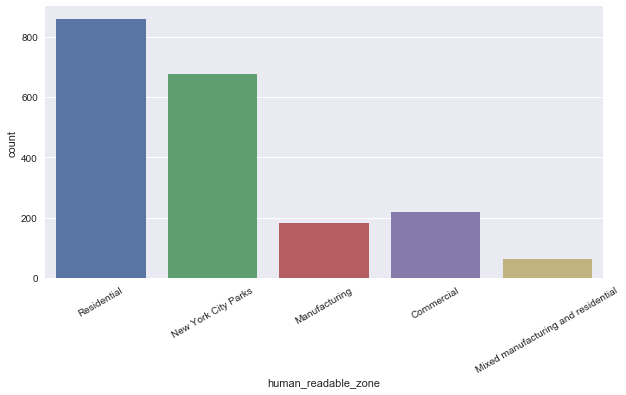

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = sns.countplot(x='human_readable_zone', data=df)
_=plt.xticks(rotation=30)

In [15]:
edit_and_save_json('Data/nyczd.geojson')

# Percent uninsured by neighborhood

In [48]:
with open('Data/NeighborhoodUninsured.geojson') as f:
    data = json.load(f)

In [49]:
data['features'][5]['properties']

{'BOROUGH': 'Bronx',
 'OBJECTID': 6,
 'SHAPE_Area': 106897846.11,
 'SHAPE_Leng': 66676.0891,
 'UHFCODE': 105,
 'UHF_NEIGH': 'Crotona - Tremont',
 'Uninsured_Perc': 25}

In [50]:
def try_to_cast(x):
    try:
        x = float(x)
    except ValueError:
        if x == '#DIV/0!':
            x = 0
    return x

def load_json_to_df(filename):
    with open(filename) as f:
        data = json.load(f)['features']
    df = []
    for d in data:
        row = d['properties']
        df.append(pd.DataFrame({'uninsured': row['Uninsured_Perc']}, index=[row['OBJECTID']]))
    df = pd.concat(df).reset_index()
    df = df.rename(columns={'index': 'Neighborhood number'})
    return df

def edit_and_save_json(filename):
    with open(filename) as f:
        data = json.load(f)
    for d in data['features']:
        d['properties']['Human_Readable_Zone'] = zoning_definitions(d['properties']['ZONEDIST'])
    with open(filename, 'w') as f:
        json.dump(data, f)

In [51]:
df = load_json_to_df('Data/NeighborhoodUninsured.geojson')

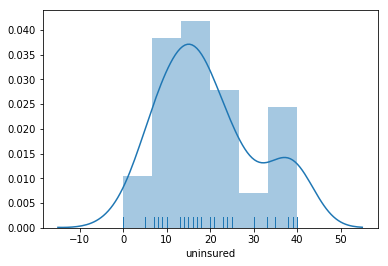

In [54]:
sns.distplot(df.uninsured, rug=True )